In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the CSV file
df = pd.read_csv('Dataset2.csv')  # Dataframe: Two-dimensional tabular data structure
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head(5)

,Cement\n(kg/m3),Blast-furnace Slag\n(kg/m3),Fly Ash\n(kg/m3),Water\n(kg/m3),Super-plasticizer\n(kg/m3),Coarse Aggregate \n(kg/m3),Fine Aggregate\n(kg/m3),Age of testing\n(day),Concrete compressive strength\n(MPa)
0,336.0,0.0,0.0,182.0,3.0,986.0,817.0,28.0,44.86
1,140.1,4.2,215.9,193.9,4.7,1049.5,710.1,28.0,26.42
2,350.0,0.0,0.0,203.0,0.0,974.0,775.0,14.0,22.53
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,28.0,42.08
4,225.0,0.0,0.0,181.0,0.0,1113.0,833.0,7.0,11.17


In [3]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Normalize the features
X_train = train_df.values[:, :8]
print(X_train)
y_train = train_df.values[:, 8]

transformer = StandardScaler().fit(X_train)  # The standardization statistics are computed independently on each feature using the training samples
X_train = transformer.transform(X_train)     # Standardize the training features using the parameters computed above
y_train = y_train.reshape((len(y_train), 1)) # Reshape to a column vector
print(y_train)


X_test = test_df.values[:, :8]
y_test = test_df.values[:, 8]
X_test = transformer.transform(X_test)       # Standardize the test features using the statistics computed on the training samples
y_test = y_test.reshape((len(y_test), 1))    # Reshape to a column vector

# Convert data to PyTorch tensors:
# 1. PyTorch functions expect tensors in float32 format
# 2. Tesnors support GPU acceleration
# 3. Tensors are more memory efficient
# 4. During backpropagation, gradients are computed and updated in float32 format
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

[[ 304.   76.    0. ...  932.  670.   90.]
 [ 500.    0.    0. ... 1033.  655.   28.]
 [ 342.   38.    0. ...  932.  670.  270.]
 ...
 [ 236.    0.    0. ...  968.  885.   28.]
 [ 424.   22.  132. ...  822.  750.   28.]
 [ 393.    0.    0. ...  940.  758.   90.]]
[[49.19]
 [69.84]
 [55.06]
 ...
 [18.42]
 [62.05]
 [48.79]]


In [4]:
# Function to plot predictions vs actual
def plot_predictions_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='red')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Predictions vs. Actual Values')
    plt.show()

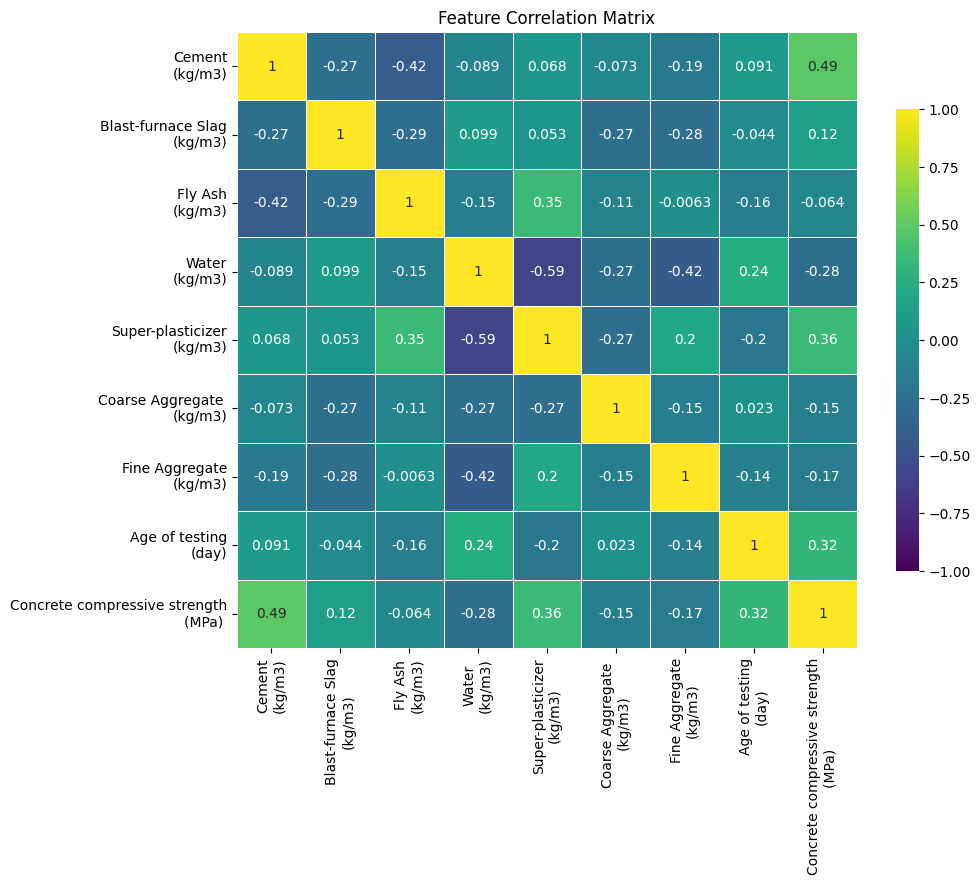

In [5]:
data = {
    "Cement (kg/m3)": np.random.rand(100),
    "Blast-furnace Slag (kg/m3)": np.random.rand(100),
    "Fly Ash (kg/m3)": np.random.rand(100),
    "Water (kg/m3)": np.random.rand(100),
    "Super-plasticizer (kg/m3)": np.random.rand(100),
    "Coarse Aggregate (kg/m3)": np.random.rand(100),
    "Fine Aggregate (kg/m3)": np.random.rand(100),
    "Age of testing (day)": np.random.randint(1, 100, 100),
    "Concrete compressive strength (MPa)": np.random.rand(100)
}


# Calculate the correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap = 'viridis', vmin=-1, vmax=1, center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

# Set the title
plt.title('Feature Correlation Matrix')

# Show the plot
plt.show()

Linear Regression - Train RMSE: 9.953592
Linear Regression - Test RMSE: 10.607529
Linear Regression - R^2 Score: 0.4832750229338346


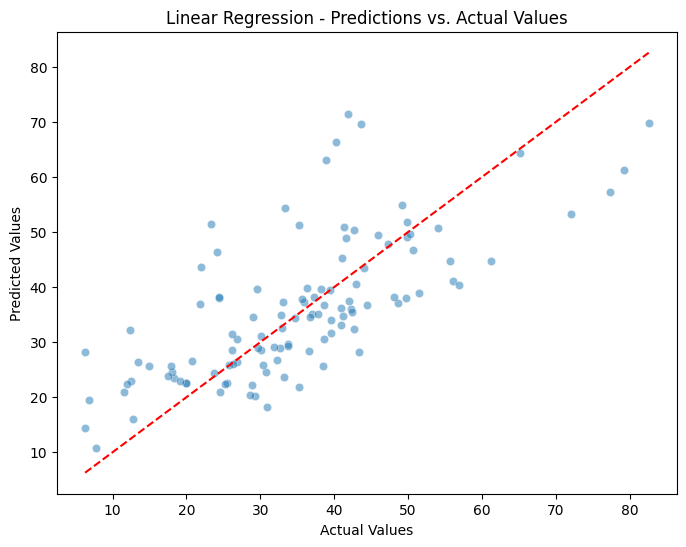

In [6]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred_train_lr = linear_reg.predict(X_train)
y_pred_test_lr = linear_reg.predict(X_test)

print("Linear Regression - Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train_lr)))
print("Linear Regression - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_lr)))
print("Linear Regression - R^2 Score:", r2_score(y_test, y_pred_test_lr))

plot_predictions_vs_actual(y_test, y_pred_test_lr, model_name="Linear Regression")

XGBoost - Train RMSE: 1.1192575
XGBoost - Test RMSE: 4.180916
XGBoost - R^2 Score: 0.9197261698179244


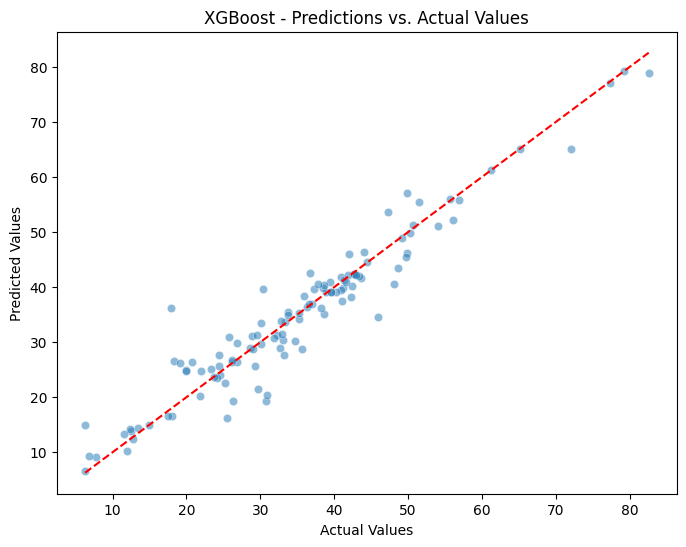

In [7]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_test_xgb = xgb_reg.predict(X_test)

print("XGBoost - Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)))
print("XGBoost - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)))
print("XGBoost - R^2 Score:", r2_score(y_test, y_pred_test_xgb))

plot_predictions_vs_actual(y_test, y_pred_test_xgb, model_name="XGBoost")

KNN - Train RMSE: 6.703139
KNN - Test RMSE: 7.94737
KNN - R^2 Score: 0.7099465935582958


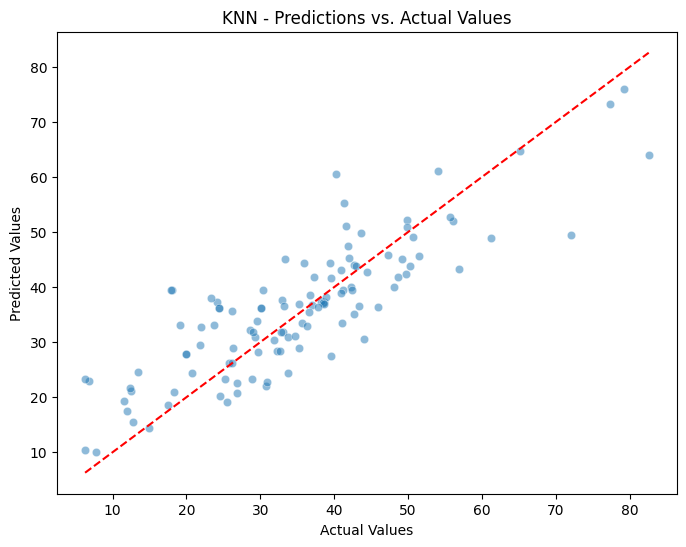

In [8]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

y_pred_train_knn = knn_reg.predict(X_train)
y_pred_test_knn = knn_reg.predict(X_test)

print("KNN - Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train_knn)))
print("KNN - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_knn)))
print("KNN - R^2 Score:", r2_score(y_test, y_pred_test_knn))

plot_predictions_vs_actual(y_test, y_pred_test_knn, model_name="KNN")

Random Forest - Train RMSE: 1.97555699654111
Random Forest - Test RMSE: 4.876081113034675
Random Forest - R^2 Score: 0.8908125039131054


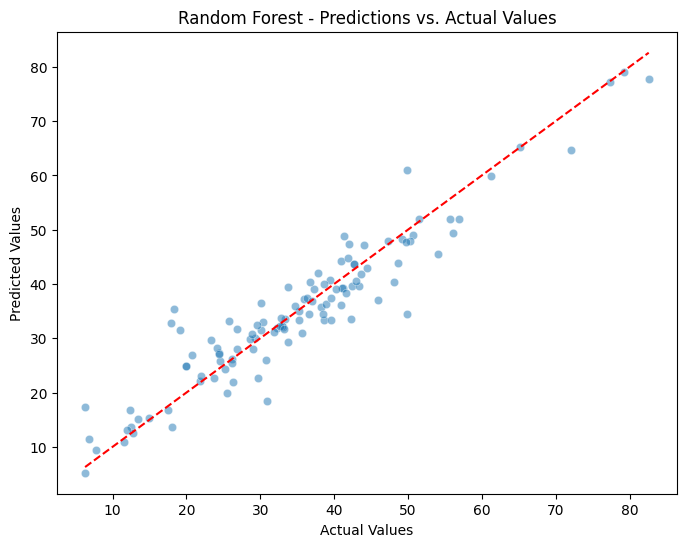

In [9]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train.ravel())  # ravel() to convert y_train to 1D array

y_pred_train_rfr = rf_reg.predict(X_train)
y_pred_test_rfr = rf_reg.predict(X_test)

print("Random Forest - Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train_rfr)))
print("Random Forest - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_rfr)))
print("Random Forest - R^2 Score:", r2_score(y_test, y_pred_test_rfr))


plot_predictions_vs_actual(y_test, y_pred_test_rfr, model_name="Random Forest")

Decision Tree - Train RMSE: 0.9264768107617103
Decision Tree - Test RMSE: 5.782726724224525
Decision Tree - R^2 Score: 0.846433529655309


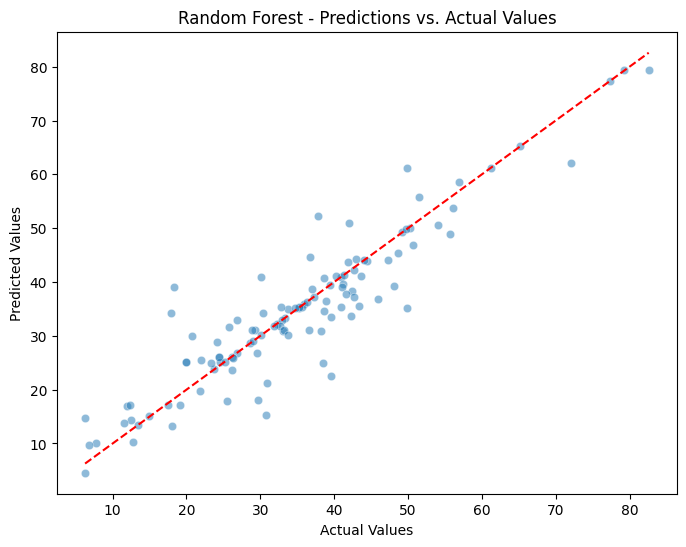

In [10]:
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

y_pred_train_dtr = dt_reg.predict(X_train)
y_pred_test_dtr = dt_reg.predict(X_test)

print("Decision Tree - Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train_dtr)))
print("Decision Tree - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_dtr)))
print("Decision Tree - R^2 Score:", r2_score(y_test, y_pred_test_dtr))

plot_predictions_vs_actual(y_test, y_pred_test_dtr, model_name="Random Forest")

In [11]:
# Define the neural network model
class Net(nn.Module):  # Neural network class
    def __init__(self):  # Constructor
        super().__init__()  # Initialize the base class
        self.layers = nn.Sequential(
                                    nn.Linear(8, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 16),
                                    nn.ReLU(),
                                    nn.Linear(16, 1)
                                    )  # Neural network layers
    def forward(self, x):  # Forward pass
        return self.layers(x)  # Apply layers to input

# Initialize the model, loss function, and optimizer
model = Net()  # Neural network model
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Stochastic Gradient Descent optimizer

# Train the model
for epoch in range(5000):  # Number of epochs
    optimizer.zero_grad()  # Clear the gradients; Otherwise, gradients accumulate over time, leading to inaccurate/exploding gradients and divergence of the model
    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)    # Compute loss
    loss.backward()  # Backward pass; compute the gradients
    optimizer.step()  # Update weights
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')  # Print loss for each epoch

Epoch 1, Loss: 1559.5897216796875
Epoch 2, Loss: 1549.5045166015625
Epoch 3, Loss: 1538.5435791015625
Epoch 4, Loss: 1526.2713623046875
Epoch 5, Loss: 1512.040283203125
Epoch 6, Loss: 1494.8319091796875
Epoch 7, Loss: 1473.1417236328125
Epoch 8, Loss: 1444.6051025390625
Epoch 9, Loss: 1405.3260498046875
Epoch 10, Loss: 1348.914794921875
Epoch 11, Loss: 1264.24755859375
Epoch 12, Loss: 1131.828125
Epoch 13, Loss: 921.1936645507812
Epoch 14, Loss: 608.1097412109375
Epoch 15, Loss: 277.1087341308594
Epoch 16, Loss: 169.68374633789062
Epoch 17, Loss: 158.8727569580078
Epoch 18, Loss: 152.05035400390625
Epoch 19, Loss: 147.30902099609375
Epoch 20, Loss: 143.71153259277344
Epoch 21, Loss: 140.756591796875
Epoch 22, Loss: 138.21397399902344
Epoch 23, Loss: 135.95921325683594
Epoch 24, Loss: 133.94866943359375
Epoch 25, Loss: 132.07858276367188
Epoch 26, Loss: 130.33697509765625
Epoch 27, Loss: 128.70730590820312
Epoch 28, Loss: 127.17843627929688
Epoch 29, Loss: 125.70713806152344
Epoch 30, L

In [12]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_test)  # Forward pass on test data

# Calculate R-squared
r2 = r2_score(y_test, predictions)  # Calculate R-squared score

print("R-squared:", r2)  # Print R-squared score

R-squared: 0.8669040649747237


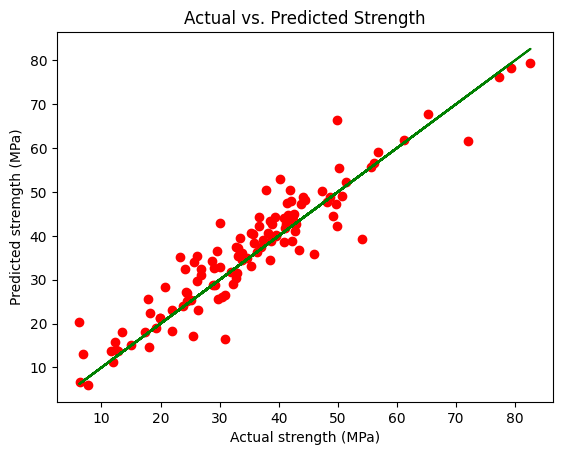

In [13]:
# Plot the results
plt.scatter(y_test, predictions, color = "red")  # Plot actual vs. predicted values
plt.plot(y_test, y_test, color = "green")  # Plot line of best fit
plt.title("Actual vs. Predicted Strength")  # Set plot title
plt.xlabel("Actual strength (MPa)")  # Set x-axis label
plt.ylabel("Predicted stremgth (MPa)")  # Set y-axis label
plt.show()  # Display the plot